In [1]:
import tensorflow as tf
import visual_data_explanation as vde
from gridworld import GridworldMdp
from utils import plot_trajectory, plot_reward, plot_reward_and_trajectories
from fast_agents import FastOptimalAgent
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

/Users/ngundotra/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
saver = tf.train.import_meta_graph("model_save_sess/.meta")
graph = tf.get_default_graph()
sess = tf.Session(graph = graph)
# necessary to reload the ** tf.VARIABLES ** that allow training to occur
saver.restore(sess, "model_save_sess/")

INFO:tensorflow:Restoring parameters from model_save_sess/


In [3]:
# This should be a list of <tf.Variable '...', >
graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'reward:0' shape=(20, 8, 8) dtype=float32_ref>,
 <tf.Variable 'VIN/bias:0' shape=(1, 1, 1, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/w0:0' shape=(3, 3, 2, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/w1:0' shape=(1, 1, 150, 5) dtype=float32_ref>,
 <tf.Variable 'VIN/w:0' shape=(3, 3, 5, 5) dtype=float32_ref>,
 <tf.Variable 'VIN/w_fb:0' shape=(3, 3, 1, 5) dtype=float32_ref>,
 <tf.Variable 'VIN/w_o:0' shape=(5, 5) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'VIN/bias/Adam:0' shape=(1, 1, 1, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/bias/Adam_1:0' shape=(1, 1, 1, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/w0/Adam:0' shape=(3, 3, 2, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/w0/Adam_1:0' shape=(3, 3, 2, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/w1/Adam:0' shape=(1, 1, 150, 5) dtype=float32_ref>,
 <tf.Variable 'VIN/w1/Adam_1:0' shape=(1, 1, 150, 5) dtype=float32_re

In [4]:
tfvars = graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
reward_var = None
for v in tfvars:
    if 'reward:0' in v.name:
        print(v)
        reward_var = v

<tf.Variable 'reward:0' shape=(20, 8, 8) dtype=float32_ref>


In [36]:
# Need 3 things: sreward_optimize_op, err, step2_cost
logits_cost = tf.add_n(graph.get_collection("losses"), name='logits_loss')
step2_cost = logits_cost

# reward_lr = 1.0 # default in config file
# reward_optimizer = tf.train.AdamOptimizer(reward_lr)
# reward_optimize_op = reward_optimizer.minimize(step2_cost, var_list=[reward_var], name='reward_optim')
reward_optimize_op = graph.get_operation_by_name('reward/Adam')

num_actions = 5
labels = tf.reshape(graph.get_tensor_by_name('y:0'), [-1, num_actions])
cp = tf.cast(tf.argmax(graph.get_tensor_by_name("output:0"), 1), tf.int32)
most_likely_labels = tf.cast(tf.argmax(labels, axis=1), tf.int32)
err = tf.reduce_mean(tf.cast(tf.not_equal(cp, most_likely_labels), dtype=tf.float32))

In [7]:
vtensors = set()
for op in graph.get_operations():
    if 'v_' in op.name and 'grad' not in op.name and '/' not in op.name:
        vtensors.add(op)

# Find all the value maps, later we'll sort them & plot them
sortable_vtensors = []
greatest = None
greatestnum = 1
for op in vtensors:
    opname = op.name.split('/')[0]
    opnum = int(opname[2:])
    sortable_vtensors.append((opnum, op))
    if opnum > greatestnum:
        greatest = op
        greatestnum = opnum
    
print(greatest)

name: "v_19"
op: "Max"
input: "q_19"
input: "v_19/reduction_indices"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "Tidx"
  value {
    type: DT_INT32
  }
}
attr {
  key: "keep_dims"
  value {
    b: true
  }
}



In [8]:
grids = vde.grids

In [9]:
mdp = GridworldMdp(grids[2])

In [10]:
walls, reward, start = mdp.convert_to_numpy_input()

In [11]:
def repeat_vector(walls, reward, num=20):
    """
    Use to fill out the batch dimension of the VIN model's input.
    Returns the batched (repeated) walls and rewards as tuple"""
    w = np.stack([walls] * 20)
    r = np.stack([reward] * 20)
    return w, r
w, r = repeat_vector(walls, reward)

In [12]:
def normalize(vals):
    vals = vals - vals.mean()
    vals = vals / (vals.max() - vals.min())
    return vals

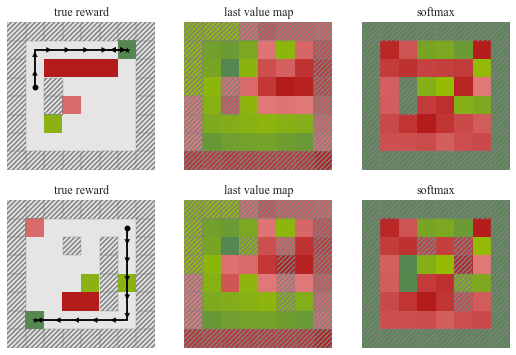

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

for ax, gr in zip(axes, grids[2:4]):
    walls, reward, start = GridworldMdp(gr).convert_to_numpy_input()
    
    # plotting softmax output of VIN (last layer)
    oo = graph.get_operation_by_name('output')
    qs = sess.run(feed_dict={'image:0': w, 'reward:0': r}, fetches=oo.outputs)[0]
    values = np.max(qs, axis=-1)
    val = np.reshape(values, (20, 8, 8))[0]
    plot_reward(normalize(val), walls, "softmax", fig, ax[2])
    # plotting actual reward
    agent = FastOptimalAgent(beta=1.0)
    plot_trajectory(walls, reward, start, agent, fig, ax[0])
    plot_reward(reward, walls, "true reward", fig, ax[0])
    # plotting last value map of VIN (last VIN block)
    rvs = greatest
    rvs = sess.run(feed_dict={'image:0':w, 'reward:0': r}, fetches=rvs.outputs)
    rvs = rvs[0][0].squeeze()
    plot_reward(normalize(rvs), walls, 'last value map', fig, ax[1])
    
fig.savefig("testing_value_maps.jpg")

In [14]:
sorted_vtensors = list(sorted(sortable_vtensors))
sorted_vtensors

[(1, <tf.Operation 'v_1' type=Max>),
 (2, <tf.Operation 'v_2' type=Max>),
 (3, <tf.Operation 'v_3' type=Max>),
 (4, <tf.Operation 'v_4' type=Max>),
 (5, <tf.Operation 'v_5' type=Max>),
 (6, <tf.Operation 'v_6' type=Max>),
 (7, <tf.Operation 'v_7' type=Max>),
 (8, <tf.Operation 'v_8' type=Max>),
 (9, <tf.Operation 'v_9' type=Max>),
 (10, <tf.Operation 'v_10' type=Max>),
 (11, <tf.Operation 'v_11' type=Max>),
 (12, <tf.Operation 'v_12' type=Max>),
 (13, <tf.Operation 'v_13' type=Max>),
 (14, <tf.Operation 'v_14' type=Max>),
 (15, <tf.Operation 'v_15' type=Max>),
 (16, <tf.Operation 'v_16' type=Max>),
 (17, <tf.Operation 'v_17' type=Max>),
 (18, <tf.Operation 'v_18' type=Max>),
 (19, <tf.Operation 'v_19' type=Max>)]

ValueError: Illegal argument(s) to subplot: (1, 3)

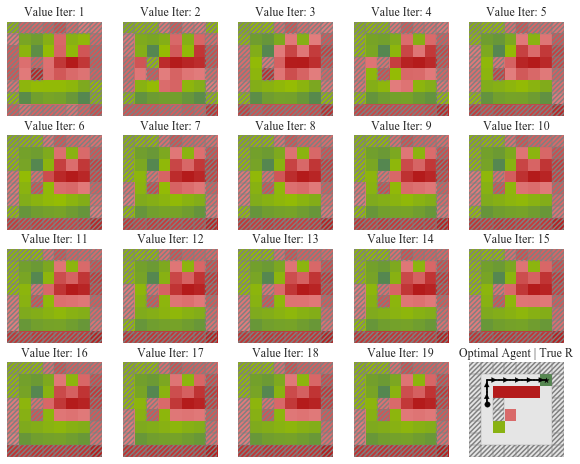

In [15]:
# Comparing value maps. Rows of 5 value maps. Starting from the first
num_cols = 5
num_rows = round(len(sortable_vtensors) // num_cols + 1)
size_scale = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * size_scale, num_rows * size_scale))


gr = grids[2] # or choose grid 3
walls, reward, start = GridworldMdp(gr).convert_to_numpy_input()
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        idx = 5 * i + j
        if idx >= len(sortable_vtensors):
            # If no more value plots, just plot the trajectory on true reward
            agent = FastOptimalAgent(beta=1.0)
            plot_trajectory(walls, reward, start, agent, fig, ax)
            plot_reward(reward, walls, "Optimal Agent | True R", fig, ax)
        else:
            # Plot value map
            opnum, op = sorted_vtensors[5 * i + j]
            vmap = sess.run(feed_dict={'image:0':w, 'reward:0': r}, fetches=op.outputs)
            vmap = vmap[0][0].squeeze()
            plot_reward(normalize(vmap), walls, 'Value Iter: {}'.format(opnum), fig, ax)
fig.savefig("ValueMapComparison-OptimalAgent-VIN-20.jpg")
            
# Plot rollout of the agent on the actual policy..., compared again with the optimal agent
# Plot rollout on inferred reward as well... 
# fig, axes = plt.subplots(1, 3)


In [42]:
def train_reward(sess, image_data, reward_data, y_data, num_epochs, verbosity, bsize=20):
        """Infers the reward using backprop, holding the planner fixed.

        Due to Tensorflow constraints, image_data must contain exactly
        batch_size number of MDPs on which the reward should be inferred.

        The rewards are initialized to the values in reward_data. If reward_data
        is None, the rewards are initialized to all zeroes.
        """
        from utils import fmt_row
        import time
        if verbosity >= 3:
            print(fmt_row(10, ["Iteration", "Train Cost", "Train Err", "Iter Time"]))
        if reward_data is None:
            reward_data = np.random.randn(*image_data.shape)

        batch_size = bsize
        num_batches = int(image_data.shape[0] / batch_size)
        costs, errs = [], []
        for batch_num in range(num_batches):
            if verbosity >= 2 and batch_num % 10 == 0:
                print('Batch {} of {}'.format(batch_num, num_batches))
            start, end = batch_num * batch_size, (batch_num + 1) * batch_size
            # We can't feed in reward_data directly to self.reward, because then
            # it will treat it as a constant and will not be able to update it
            # with backprop. Instead, we first run an op that assigns the
            # reward, and only then do the backprop.
            fd = {
                "reward_input:0": reward_data[start:end],
            }
            assign_reward = reward_var.assign(graph.get_tensor_by_name("reward_input:0"))
            sess.run([assign_reward], feed_dict=fd)

            if batch_num % 10 == 0:
                costs.append([])
                errs.append([])
            for epoch in range(num_epochs):
                tstart = time.time()
                fd = {
                    "image:0": image_data[start:end],
                    "y:0": y_data[start:end]
                }
                _, e_, c_ = sess.run(
                    [reward_optimize_op, err, step2_cost],
                    feed_dict=fd)
                elapsed = time.time() - tstart
                if verbosity >= 3 and batch_num % 10 == 0:
                    print(fmt_row(10, [epoch, c_, e_, elapsed]))
                    costs[-1].append(c_)
                    errs[-1].append(e_)

            reward_data[start:end] = reward_var.eval(sess)

#         logs['train_reward_costs'].append(costs)
#         logs['train_reward_errs'].append(errs)
        return reward_data

In [31]:
# generate_data_for_reward( agent, num_w/oreward)
# y_irl = ydata = 4th return of generate data AKA labels
imsize = 8
def generate_data_for_reward(mdp, agent):
    from utils import Distribution
    from gridworld import Direction
    def dist_to_numpy(dist):
        return dist.as_numpy_array(Direction.get_number_from_direction, num_actions)

    def action(state):
        # Walls are invalid states and the MDP will refuse to give an action for
        # them. However, the VIN's architecture requires it to provide an action
        # distribution for walls too, so hardcode it to always be STAY.
        x, y = state
        if mdp.walls[y][x]:
            return dist_to_numpy(Distribution({Direction.STAY : 1}))
        return dist_to_numpy(agent.get_action_distribution(state))
    
    agent.set_mdp(mdp)
    action_dists = [[action((x, y)) for x in range(imsize)] for y in range(imsize)]
    action_dists = np.array(action_dists)

    walls, rewards, start_state = mdp.convert_to_numpy_input()
    return action_dists


 Iteration | Train Cost |  Train Err |  Iter Time
Batch 0 of 1
         0 |  1.0335904 | 0.39765626 | 0.00684714
         1 |  1.0335904 | 0.39765626 | 0.00657701
         2 |  1.0335904 | 0.39765626 |  0.0068779
         3 |  1.0335904 | 0.39765626 | 0.00747228
         4 |  1.0335904 | 0.39765626 | 0.00656724
         5 |  1.0335904 | 0.39765626 | 0.00610209
         6 |  1.0335904 | 0.39765626 | 0.00555301
         7 |  1.0335904 | 0.39765626 | 0.00560713
         8 |  1.0335904 | 0.39765626 |   0.005404
         9 |  1.0335904 | 0.39765626 | 0.00531006
        10 |  1.0335904 | 0.39765626 | 0.00523496
        11 |  1.0335904 | 0.39765626 | 0.00524855
        12 |  1.0335904 | 0.39765626 | 0.00522804
        13 |  1.0335904 | 0.39765626 | 0.00524306
        14 |  1.0335904 | 0.39765626 |  0.0051868
        15 |  1.0335904 | 0.39765626 | 0.00517988
        16 |  1.0335904 | 0.39765626 | 0.00516319
        17 |  1.0335904 | 0.39765626 | 0.00525999
        18 |  1.0335904 | 0.39765626 

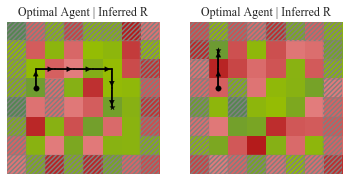

In [64]:
def visualize_inferred_on_grid(grid, train_agent, optimal_agent, fig, ax):
    mdp = GridworldMdp(gr)
    walls, reward, start = mdp.convert_to_numpy_input()
    
    agent = FastOptimalAgent(beta=1.0)
    y_data = generate_data_for_reward(mdp, train_agent)

    repeat_walls, repeat_ys = repeat_vector(walls, y_data)
    reward_data = train_reward(sess, repeat_walls, None, repeat_ys, 40, 3, bsize=20)

    agent = FastOptimalAgent(beta=None)
    plot_trajectory(walls, reward_data[0], start, optimal_agent, fig, ax)
    plot_reward(reward_data[0], walls, "Optimal Agent | Inferred R", fig, ax)

fig, axes = plt.subplots(1, 2)
visualize_inferred_on_grid(grids[2], FastOptimalAgent(beta=1.0), FastOptimalAgent(beta=None), fig, axes[0])
visualize_inferred_on_grid(grids[3], FastOptimalAgent(beta=1.0), FastOptimalAgent(beta=None), fig, axes[1])